# Session 8: Extensions and Special Topics

## Event Studies in Finance and Economics - Summer School

---

### Learning Objectives

By the end of this session, you will be able to:

1. Handle intraday event studies with high-frequency data
2. Implement event studies for bonds and other asset classes
3. Apply event study methods to international/multi-market settings
4. Use difference-in-differences with event studies
5. Account for confounding events and event contamination
6. Implement rolling window and time-varying approaches

---

## 1. Introduction: Beyond Standard Event Studies

### Extensions Covered

| Extension | Application | Key Challenge |
|-----------|-------------|---------------|
| **Intraday** | HFT, news announcements | Microstructure noise |
| **Multi-asset** | Bonds, options, FX | Different return dynamics |
| **International** | Cross-border events | Time zones, market linkages |
| **Diff-in-Diff** | Policy evaluation | Control group selection |
| **Confounding events** | Earnings + M&A | Isolation of effects |
| **Time-varying** | Changing market conditions | Parameter instability |

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import yfinance as yf
import statsmodels.api as sm
from datetime import datetime, timedelta
from dataclasses import dataclass
from typing import List, Dict, Optional, Tuple
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
print("Libraries loaded!")

Libraries loaded!


## 2. Intraday Event Studies

### When to Use Intraday Data

- **Precise event timing**: Fed announcements, earnings releases
- **High-frequency trading**: Algorithmic response to news
- **Price discovery**: How quickly is information incorporated?

### Challenges

1. **Microstructure noise**: Bid-ask bounce, discrete prices
2. **Intraday patterns**: U-shaped volatility, lunch effect
3. **Data requirements**: Tick or minute-level data
4. **Benchmark selection**: Intraday expected returns

In [27]:
def simulate_intraday_data(event_time_minutes: int = 180,  # 3 hours into trading
                           trading_minutes: int = 390,      # 6.5 hours
                           event_impact: float = 0.0005,      # 0.05% immediate impact
                           n_days: int = 5) -> pd.DataFrame:
    """
    Simulate intraday price data around an event.
    
    Includes realistic features:
    - U-shaped intraday volatility
    - Event impact at specific time
    - Mean reversion after impact
    """
    np.random.seed(42)
    
    all_data = []
    base_price = 100
    
    for day in range(-n_days//2, n_days//2 + 1):
        # Generate minute-by-minute data
        minutes = np.arange(trading_minutes)
        
        # U-shaped volatility pattern
        vol_pattern = 0.0002 * (1 + 2*np.exp(-minutes/60) + 2*np.exp(-(trading_minutes-minutes)/60))
        
        # Generate returns
        returns = np.random.normal(0, vol_pattern)
        
        # Add event impact on event day
        if day == 0:
            returns[event_time_minutes] += event_impact
            # Slight mean reversion
            returns[event_time_minutes+1:event_time_minutes+30] -= event_impact * 0.1 / 30
        
        # Calculate prices
        prices = base_price * np.cumprod(1 + returns)
        base_price = prices[-1]  # Carry to next day
        
        # Create timestamps (9:30 AM start)
        date = pd.Timestamp('2023-07-26') + timedelta(days=day)
        timestamps = [date + timedelta(hours=9, minutes=30) + timedelta(minutes=int(m)) 
                      for m in minutes]
        
        day_df = pd.DataFrame({
            'timestamp': timestamps,
            'price': prices,
            'return': returns,
            'day': day,
            'minute': minutes
        })
        all_data.append(day_df)
    
    return pd.concat(all_data, ignore_index=True)


# Simulate intraday data
intraday_data = simulate_intraday_data(event_time_minutes=180, event_impact=0.005)
print(f"Simulated {len(intraday_data)} minute observations")
print(f"Event day data points: {len(intraday_data[intraday_data['day'] == 0])}")

Simulated 2340 minute observations
Event day data points: 390


In [29]:
def intraday_event_study(data: pd.DataFrame, 
                          event_minute: int,
                          pre_minutes: int = 30,
                          post_minutes: int = 60) -> Dict:
    """
    Conduct intraday event study.
    
    Uses pre-event period on same day as benchmark.
    """
    event_day = data[data['day'] == 0].copy()
    
    # Pre-event benchmark (e.g., morning before announcement)
    pre_event = event_day[(event_day['minute'] >= event_minute - pre_minutes - 60) & 
                          (event_day['minute'] < event_minute - pre_minutes)]
    
    # Expected return per minute (from pre-event period)
    expected_return = pre_event['return'].mean()
    expected_vol = pre_event['return'].std()
    
    # Event window
    event_window = event_day[(event_day['minute'] >= event_minute - pre_minutes) & 
                             (event_day['minute'] <= event_minute + post_minutes)].copy()
    
    # Abnormal returns
    event_window['AR'] = event_window['return'] - expected_return
    event_window['event_time'] = event_window['minute'] - event_minute
    
    # Cumulative abnormal returns
    event_window['CAR'] = event_window['AR'].cumsum()
    
    # Key statistics
    car_total = event_window['CAR'].iloc[-1]
    car_immediate = event_window[event_window['event_time'] <= 5]['AR'].sum()
    
    # t-statistic (using pre-event volatility)
    n_minutes = len(event_window)
    car_se = expected_vol * np.sqrt(n_minutes)
    t_stat = car_total / car_se if car_se > 0 else 0
    
    return {
        'event_window': event_window,
        'car_total': car_total,
        'car_immediate': car_immediate,
        't_stat': t_stat,
        'expected_vol': expected_vol
    }


# Run intraday event study
intraday_results = intraday_event_study(intraday_data, event_minute=180, 
                                         pre_minutes=30, post_minutes=60)

print("Intraday Event Study Results:")
print("="*50)
print(f"Total CAR (30 min pre to 60 min post): {intraday_results['car_total']*100:.3f}%")
print(f"Immediate CAR (0 to +5 min): {intraday_results['car_immediate']*100:.3f}%")
print(f"t-statistic: {intraday_results['t_stat']:.2f}")

Intraday Event Study Results:
Total CAR (30 min pre to 60 min post): 0.333%
Immediate CAR (0 to +5 min): 0.297%
t-statistic: 1.46


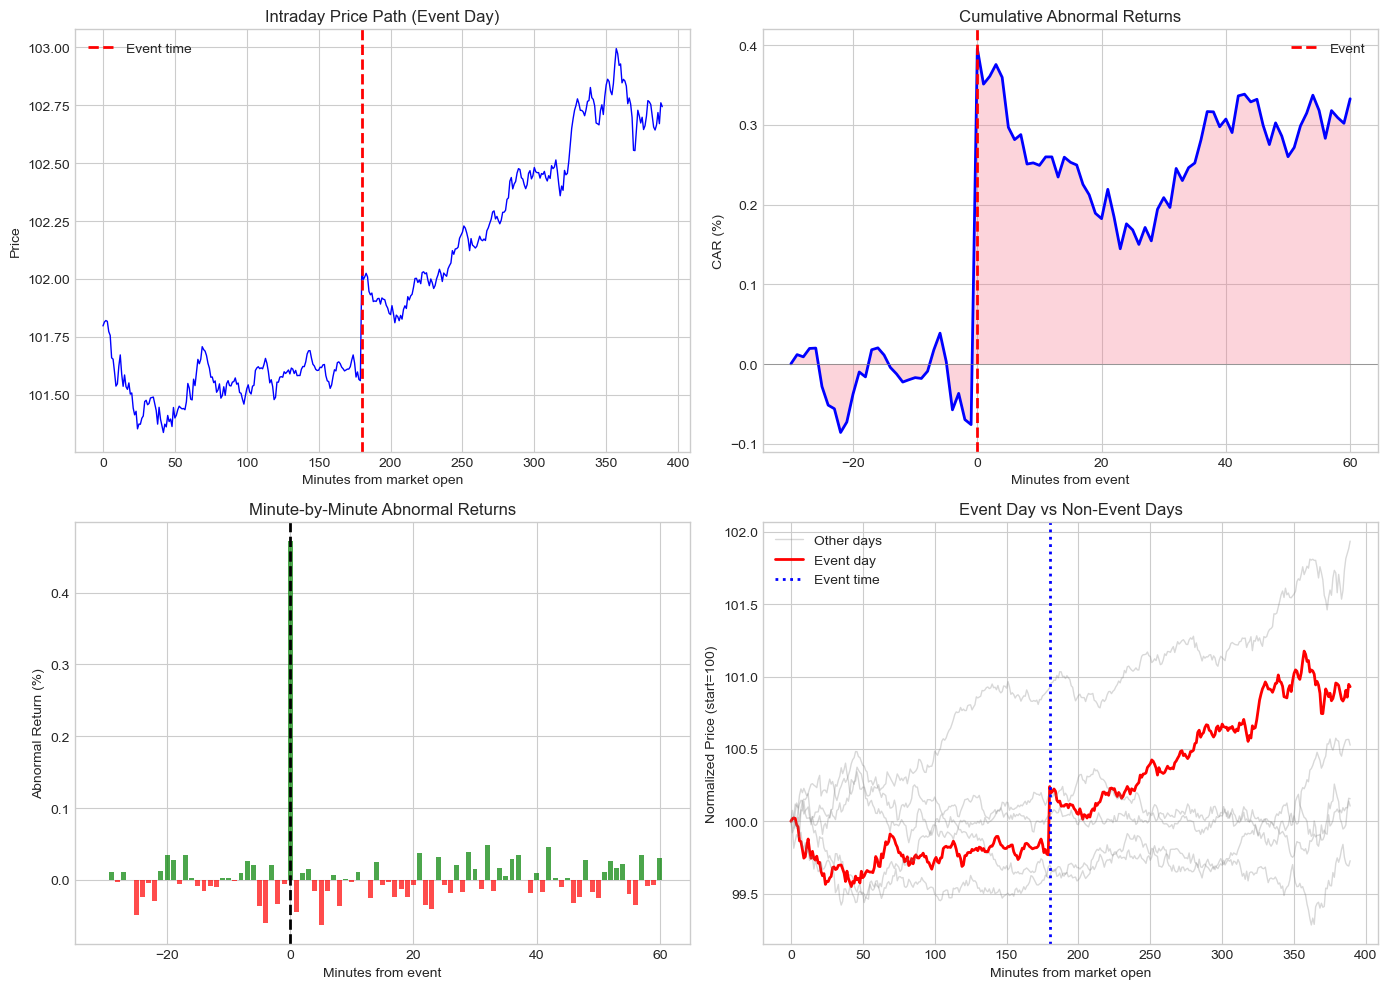

In [31]:
# Visualize intraday event study
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

event_window = intraday_results['event_window']

# Price path on event day
ax1 = axes[0, 0]
event_day = intraday_data[intraday_data['day'] == 0]
ax1.plot(event_day['minute'], event_day['price'], 'b-', linewidth=1)
ax1.axvline(180, color='red', linestyle='--', linewidth=2, label='Event time')
ax1.set_xlabel('Minutes from market open')
ax1.set_ylabel('Price')
ax1.set_title('Intraday Price Path (Event Day)')
ax1.legend()

# Cumulative abnormal returns
ax2 = axes[0, 1]
ax2.plot(event_window['event_time'], event_window['CAR']*100, 'b-', linewidth=2)
ax2.axhline(0, color='gray', linestyle='-', linewidth=0.5)
ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='Event')
ax2.fill_between(event_window['event_time'], 0, event_window['CAR']*100, alpha=0.3)
ax2.set_xlabel('Minutes from event')
ax2.set_ylabel('CAR (%)')
ax2.set_title('Cumulative Abnormal Returns')
ax2.legend()

# Minute-by-minute abnormal returns
ax3 = axes[1, 0]
colors = ['green' if x > 0 else 'red' for x in event_window['AR']]
ax3.bar(event_window['event_time'], event_window['AR']*100, color=colors, alpha=0.7)
ax3.axvline(0, color='black', linestyle='--', linewidth=2)
ax3.set_xlabel('Minutes from event')
ax3.set_ylabel('Abnormal Return (%)')
ax3.set_title('Minute-by-Minute Abnormal Returns')

# Compare event day to non-event days
ax4 = axes[1, 1]
for day in intraday_data['day'].unique():
    day_data = intraday_data[intraday_data['day'] == day]
    normalized = day_data['price'] / day_data['price'].iloc[0] * 100
    color = 'red' if day == 0 else 'gray'
    alpha = 1.0 if day == 0 else 0.3
    lw = 2 if day == 0 else 1
    label = 'Event day' if day == 0 else ('Other days' if day == -2 else None)
    ax4.plot(day_data['minute'], normalized, color=color, alpha=alpha, linewidth=lw, label=label)

ax4.axvline(180, color='blue', linestyle=':', linewidth=2, label='Event time')
ax4.set_xlabel('Minutes from market open')
ax4.set_ylabel('Normalized Price (start=100)')
ax4.set_title('Event Day vs Non-Event Days')
ax4.legend()

plt.tight_layout()
plt.show()

## 3. Multi-Asset Event Studies

### Beyond Equities

Event studies can be applied to:
- **Corporate bonds**: Credit events, rating changes
- **Options**: Implied volatility changes
- **Foreign exchange**: Central bank announcements
- **Commodities**: Supply/demand shocks

### Bond Event Study Considerations

1. **Illiquidity**: Bonds trade less frequently
2. **Duration/convexity**: Interest rate sensitivity
3. **Credit spread**: Isolate credit-specific effects
4. **Multiple bonds per issuer**: Aggregate or analyze separately

In [34]:
def simulate_bond_event_data(n_firms: int = 15,
                              event_type: str = 'downgrade') -> pd.DataFrame:
    """
    Simulate corporate bond event study data.
    
    Models credit spread changes around rating events.
    """
    np.random.seed(42)
    
    data = []
    
    for i in range(n_firms):
        # Firm characteristics
        initial_spread = np.random.uniform(100, 400)  # bps
        duration = np.random.uniform(3, 10)  # years
        
        # Event impact (downgrades increase spreads)
        if event_type == 'downgrade':
            spread_change = np.random.uniform(20, 80)  # bps widening
        else:  # upgrade
            spread_change = np.random.uniform(-60, -10)  # bps tightening
        
        # Daily spread changes (21 days: -10 to +10)
        for t in range(-10, 11):
            noise = np.random.normal(0, 5)  # Daily noise
            
            if t == 0:  # Event day
                spread_delta = spread_change * 0.6 + noise  # 60% on event day
            elif t == 1:  # Day after
                spread_delta = spread_change * 0.2 + noise  # 20% drift
            elif t == 2:
                spread_delta = spread_change * 0.1 + noise  # 10% more drift
            else:
                spread_delta = noise
            
            # Bond return approximation: -duration * spread_change / 10000
            bond_return = -duration * spread_delta / 10000
            
            data.append({
                'firm_id': i,
                'event_time': t,
                'spread_change': spread_delta,
                'bond_return': bond_return,
                'duration': duration,
                'initial_spread': initial_spread
            })
    
    return pd.DataFrame(data)


# Simulate bond data
bond_data = simulate_bond_event_data(n_firms=15, event_type='downgrade')
print(f"Simulated {len(bond_data)} bond-day observations for {bond_data['firm_id'].nunique()} firms")

Simulated 315 bond-day observations for 15 firms


In [36]:
def bond_event_study(data: pd.DataFrame) -> Dict:
    """
    Analyze bond market response to credit events.
    """
    # Average spread change by event time
    avg_by_time = data.groupby('event_time').agg({
        'spread_change': ['mean', 'std', 'count'],
        'bond_return': ['mean', 'std']
    })
    avg_by_time.columns = ['spread_mean', 'spread_std', 'n', 'return_mean', 'return_std']
    avg_by_time = avg_by_time.reset_index()
    
    # Cumulative spread change
    avg_by_time['cum_spread'] = avg_by_time['spread_mean'].cumsum()
    avg_by_time['cum_return'] = avg_by_time['return_mean'].cumsum()
    
    # Standard errors
    avg_by_time['spread_se'] = avg_by_time['spread_std'] / np.sqrt(avg_by_time['n'])
    
    # t-statistics
    avg_by_time['t_stat'] = avg_by_time['spread_mean'] / avg_by_time['spread_se']
    
    # Windows
    windows = {
        '(0,0)': data[data['event_time'] == 0]['spread_change'].values,
        '(-1,+1)': data[data['event_time'].between(-1, 1)].groupby('firm_id')['spread_change'].sum().values,
        '(0,+5)': data[data['event_time'].between(0, 5)].groupby('firm_id')['spread_change'].sum().values,
    }
    
    window_stats = {}
    for name, values in windows.items():
        t, p = stats.ttest_1samp(values, 0)
        window_stats[name] = {
            'mean': np.mean(values),
            'std': np.std(values),
            't_stat': t,
            'p_value': p
        }
    
    return {
        'time_series': avg_by_time,
        'window_stats': window_stats
    }


bond_results = bond_event_study(bond_data)

print("Bond Event Study: Credit Rating Downgrade")
print("="*60)
print("\nCumulative Spread Change by Window (bps):")
print("-"*60)
for window, stats_dict in bond_results['window_stats'].items():
    sig = '***' if stats_dict['p_value'] < 0.01 else '**' if stats_dict['p_value'] < 0.05 else '*' if stats_dict['p_value'] < 0.10 else ''
    print(f"  {window}: {stats_dict['mean']:+.1f} bps (t={stats_dict['t_stat']:.2f}{sig})")

Bond Event Study: Credit Rating Downgrade

Cumulative Spread Change by Window (bps):
------------------------------------------------------------
  (0,0): +29.2 bps (t=8.84***)
  (-1,+1): +40.1 bps (t=8.66***)
  (0,+5): +43.5 bps (t=6.56***)


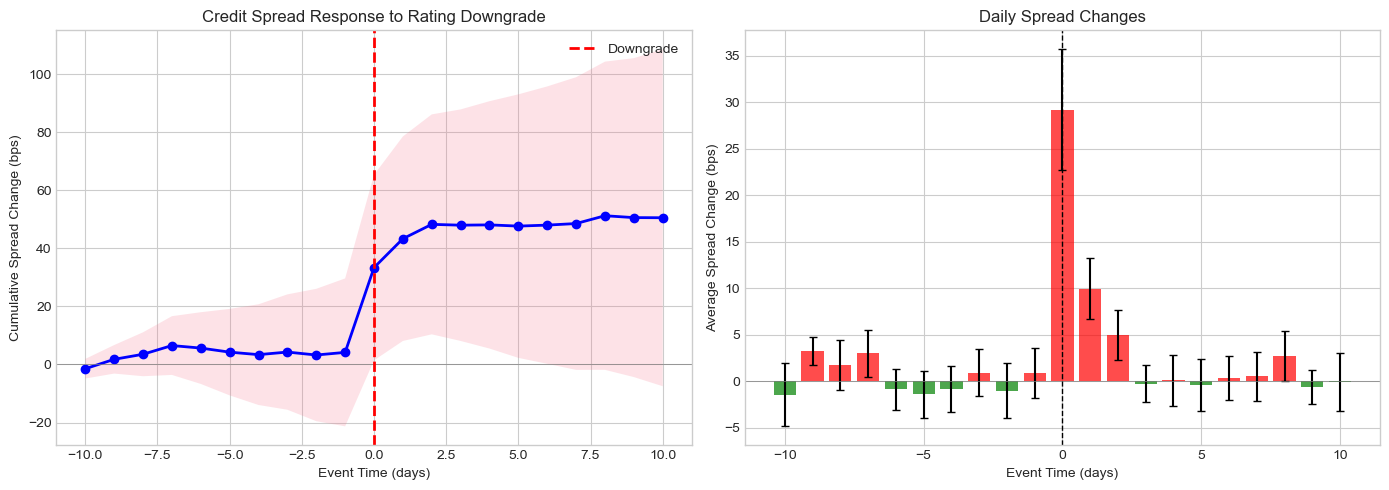

In [38]:
# Visualize bond event study
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ts = bond_results['time_series']

# Cumulative spread change
ax1 = axes[0]
ax1.plot(ts['event_time'], ts['cum_spread'], 'b-', linewidth=2, marker='o')
ax1.fill_between(ts['event_time'], 
                  ts['cum_spread'] - 1.96*ts['spread_se'].cumsum(),
                  ts['cum_spread'] + 1.96*ts['spread_se'].cumsum(),
                  alpha=0.2)
ax1.axhline(0, color='gray', linestyle='-', linewidth=0.5)
ax1.axvline(0, color='red', linestyle='--', linewidth=2, label='Downgrade')
ax1.set_xlabel('Event Time (days)')
ax1.set_ylabel('Cumulative Spread Change (bps)')
ax1.set_title('Credit Spread Response to Rating Downgrade')
ax1.legend()

# Daily spread changes
ax2 = axes[1]
colors = ['red' if x > 0 else 'green' for x in ts['spread_mean']]
ax2.bar(ts['event_time'], ts['spread_mean'], color=colors, alpha=0.7, 
        yerr=ts['spread_se']*1.96, capsize=3)
ax2.axhline(0, color='gray', linestyle='-', linewidth=0.5)
ax2.axvline(0, color='black', linestyle='--', linewidth=1)
ax2.set_xlabel('Event Time (days)')
ax2.set_ylabel('Average Spread Change (bps)')
ax2.set_title('Daily Spread Changes')

plt.tight_layout()
plt.show()

## 4. International Event Studies

### Challenges

1. **Time zones**: Events occur at different local times
2. **Non-synchronous trading**: Markets open/close at different times
3. **Currency effects**: Local vs USD returns
4. **Market linkages**: Spillovers across markets

### Handling Time Zones

- Define event day based on market where event occurs
- Account for information transmission delays
- Consider overnight returns for earlier markets

In [46]:
def download_international_data(tickers: Dict[str, str], 
                                 start_date: str, 
                                 end_date: str) -> pd.DataFrame:
    """
    Download international stock data.
    
    Args:
        tickers: Dict mapping market name to ticker symbol
    """
    data = {}
    
    for market, ticker in tickers.items():
        try:
            prices = yf.download(ticker, start=start_date, end=end_date, progress=False)['Close']
            data[market] = prices.squeeze().pct_change()
        except Exception as e:
            print(f"Failed to download {market}: {e}")
    
    df = pd.DataFrame(data).dropna()
    return df


# International indices
international_tickers = {
    'US': '^GSPC',        # S&P 500
    'Europe': '^STOXX50E', # Euro Stoxx 50
    'UK': '^FTSE',        # FTSE 100
    'Japan': '^N225',     # Nikkei 225
    'China': '000001.SS', # Shanghai Composite
}

print("Downloading international market data...")
intl_data = download_international_data(international_tickers, '2022-01-01', '2023-12-31')
print(f"Downloaded {len(intl_data)} trading days for {len(intl_data.columns)} markets")

Downloaded 428 trading days for 5 markets


In [47]:
def international_event_study(data: pd.DataFrame,
                               event_date: str,
                               event_market: str,
                               estimation_window: int = 120,
                               event_window: Tuple[int, int] = (-5, 5)) -> Dict:
    """
    Study international market response to event.
    
    Estimates market model for each market using event market as benchmark.
    """
    event_dt = pd.to_datetime(event_date)
    
    # Find event date in data
    if event_dt not in data.index:
        idx = data.index.get_indexer([event_dt], method='nearest')[0]
        event_dt = data.index[idx]
    
    event_idx = data.index.get_loc(event_dt)
    
    results = {}
    
    for market in data.columns:
        if market == event_market:
            continue
        
        # Estimation period
        est_start = max(0, event_idx - estimation_window - 10)
        est_end = event_idx - 10
        
        est_data = data.iloc[est_start:est_end]
        
        # Market model: R_market = alpha + beta * R_event_market
        y = est_data[market].dropna()
        x = est_data[event_market].loc[y.index]
        
        if len(y) < 30:
            continue
        
        X = sm.add_constant(x)
        model = sm.OLS(y, X).fit()
        
        # Event window
        evt_start = event_idx + event_window[0]
        evt_end = event_idx + event_window[1] + 1
        evt_data = data.iloc[evt_start:evt_end].copy()
        
        # Abnormal returns
        expected = model.params['const'] + model.params[event_market] * evt_data[event_market]
        ar = evt_data[market] - expected
        car = ar.cumsum()
        
        # Statistics
        sigma = np.std(model.resid)
        car_total = car.iloc[-1] if len(car) > 0 else np.nan
        t_stat = car_total / (sigma * np.sqrt(len(ar))) if sigma > 0 and len(ar) > 0 else np.nan
        
        results[market] = {
            'beta': model.params[event_market],
            'ar_series': ar,
            'car_series': car,
            'car_total': car_total,
            't_stat': t_stat,
            'sigma': sigma
        }
    
    return results


# Study US Fed announcement spillovers (example date)
fed_event = '2023-03-22'  # FOMC meeting

intl_results = international_event_study(intl_data, fed_event, 'US', 
                                          estimation_window=120, event_window=(-2, 5))

print(f"\nInternational Spillovers from US Event ({fed_event}):")
print("="*70)
print(f"{'Market':<15} {'Beta':>10} {'CAR':>12} {'t-stat':>10}")
print("-"*70)
for market, stats in intl_results.items():
    if not np.isnan(stats['car_total']):
        sig = '***' if abs(stats['t_stat']) > 2.58 else '**' if abs(stats['t_stat']) > 1.96 else '*' if abs(stats['t_stat']) > 1.65 else ''
        print(f"{market:<15} {stats['beta']:>10.3f} {stats['car_total']*100:>+11.2f}% {stats['t_stat']:>8.2f}{sig}")


International Spillovers from US Event (2023-03-22):
Market                Beta          CAR     t-stat
----------------------------------------------------------------------
Europe               0.450       +0.28%     0.12
UK                   0.182       -0.02%    -0.01
Japan               -0.043       +3.55%     1.16
China               -0.017       -0.07%    -0.03


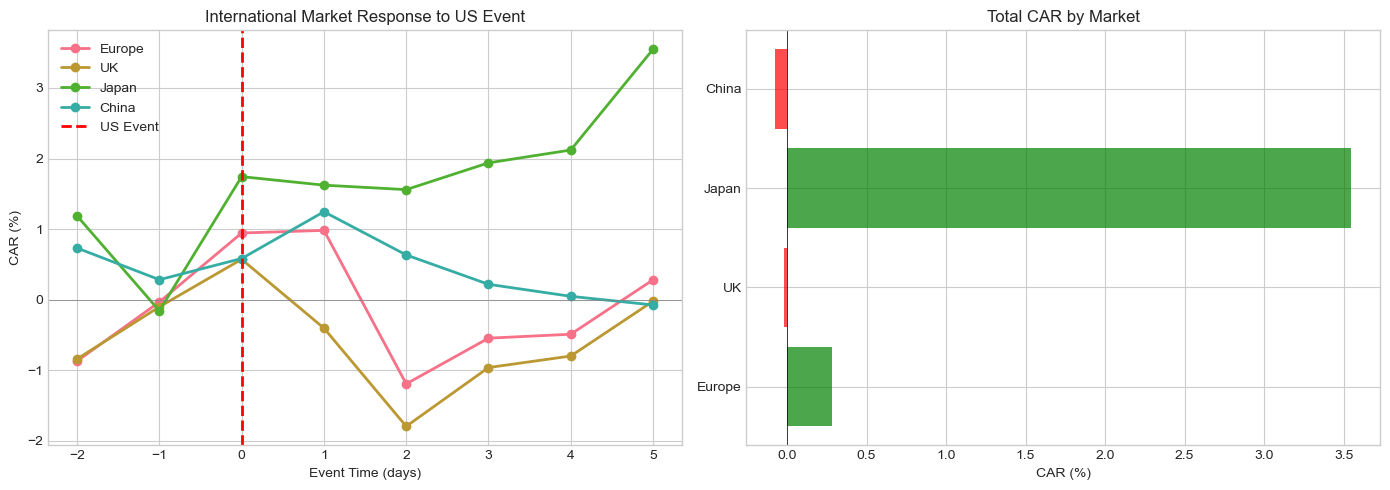

In [50]:
# Visualize international spillovers
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# CAR paths
ax1 = axes[0]
for market, stats in intl_results.items():
    if not stats['car_series'].empty:
        event_time = range(-2, -2 + len(stats['car_series']))
        ax1.plot(event_time, stats['car_series']*100, marker='o', label=market, linewidth=2)

ax1.axhline(0, color='gray', linestyle='-', linewidth=0.5)
ax1.axvline(0, color='red', linestyle='--', linewidth=2, label='US Event')
ax1.set_xlabel('Event Time (days)')
ax1.set_ylabel('CAR (%)')
ax1.set_title('International Market Response to US Event')
ax1.legend()

# Bar chart of total CARs
ax2 = axes[1]
markets = [m for m in intl_results.keys() if not np.isnan(intl_results[m]['car_total'])]
cars = [intl_results[m]['car_total']*100 for m in markets]
colors = ['green' if c > 0 else 'red' for c in cars]

ax2.barh(markets, cars, color=colors, alpha=0.7)
ax2.axvline(0, color='black', linestyle='-', linewidth=0.5)
ax2.set_xlabel('CAR (%)')
ax2.set_title('Total CAR by Market')

plt.tight_layout()
plt.show()

## 5. Difference-in-Differences Event Study

### Concept

Combine event study with diff-in-diff to:
- Compare treated vs control firms
- Account for common time trends
- Identify causal effects of policies/regulations

### Model

$$R_{i,t} = \alpha + \beta_1 \cdot Post_t + \beta_2 \cdot Treated_i + \beta_3 \cdot (Post_t \times Treated_i) + \epsilon_{i,t}$$

- $\beta_3$: Difference-in-differences estimate (causal effect)

In [53]:
def simulate_did_data(n_treated: int = 20,
                       n_control: int = 30,
                       treatment_effect: float = 0.02,
                       pre_periods: int = 60,
                       post_periods: int = 60) -> pd.DataFrame:
    """
    Simulate data for difference-in-differences event study.
    """
    np.random.seed(42)
    
    data = []
    
    # Common time trend
    time_trend = np.concatenate([
        np.linspace(0, 0.001, pre_periods),
        np.linspace(0.001, 0.002, post_periods)
    ])
    
    for i in range(n_treated + n_control):
        treated = i < n_treated
        firm_fe = np.random.normal(0, 0.001)  # Firm fixed effect
        
        for t in range(-pre_periods, post_periods):
            post = t >= 0
            
            # Base return
            ret = firm_fe + time_trend[t + pre_periods]
            
            # Add noise
            ret += np.random.normal(0, 0.02)
            
            # Treatment effect (only for treated firms after event)
            if treated and post:
                # Gradual effect
                effect_strength = min(t / 20, 1)  # Ramp up over 20 days
                ret += treatment_effect * effect_strength / post_periods
            
            data.append({
                'firm_id': i,
                'treated': treated,
                'event_time': t,
                'post': post,
                'return': ret
            })
    
    return pd.DataFrame(data)


# Simulate DiD data
did_data = simulate_did_data(n_treated=20, n_control=30, treatment_effect=0.03)
print(f"Simulated {len(did_data)} firm-day observations")
print(f"Treated firms: {did_data[did_data['treated']]['firm_id'].nunique()}")
print(f"Control firms: {did_data[~did_data['treated']]['firm_id'].nunique()}")

Simulated 6000 firm-day observations
Treated firms: 20
Control firms: 30


In [55]:
def diff_in_diff_event_study(data: pd.DataFrame) -> Dict:
    """
    Run difference-in-differences event study.
    """
    # Create interaction term
    data = data.copy()
    data['treated_post'] = data['treated'].astype(int) * data['post'].astype(int)
    
    # DiD regression
    y = data['return']
    X = sm.add_constant(data[['post', 'treated', 'treated_post']].astype(float))
    
    model = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': data['firm_id']})
    
    # Calculate cumulative returns by group
    cum_returns = data.groupby(['event_time', 'treated']).agg({
        'return': 'mean'
    }).reset_index()
    
    cum_returns['cum_return'] = cum_returns.groupby('treated')['return'].cumsum()
    
    return {
        'model': model,
        'did_estimate': model.params['treated_post'],
        'did_se': model.bse['treated_post'],
        'did_tstat': model.tvalues['treated_post'],
        'did_pvalue': model.pvalues['treated_post'],
        'cum_returns': cum_returns
    }


did_results = diff_in_diff_event_study(did_data)

print("Difference-in-Differences Event Study Results:")
print("="*60)
print(f"\nDiD Estimate (β₃): {did_results['did_estimate']*100:.4f}%")
print(f"Clustered SE: {did_results['did_se']*100:.4f}%")
print(f"t-statistic: {did_results['did_tstat']:.2f}")
print(f"p-value: {did_results['did_pvalue']:.4f}")

print("\n" + "="*60)
print("Full Regression Results:")
print(did_results['model'].summary().tables[1])

Difference-in-Differences Event Study Results:

DiD Estimate (β₃): -0.0592%
Clustered SE: 0.1043%
t-statistic: -0.57
p-value: 0.5705

Full Regression Results:
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.613e-06      0.000     -0.006      0.995      -0.001       0.001
post             0.0010      0.001      1.867      0.062   -5.16e-05       0.002
treated          0.0018      0.001      2.305      0.021       0.000       0.003
treated_post    -0.0006      0.001     -0.567      0.570      -0.003       0.001


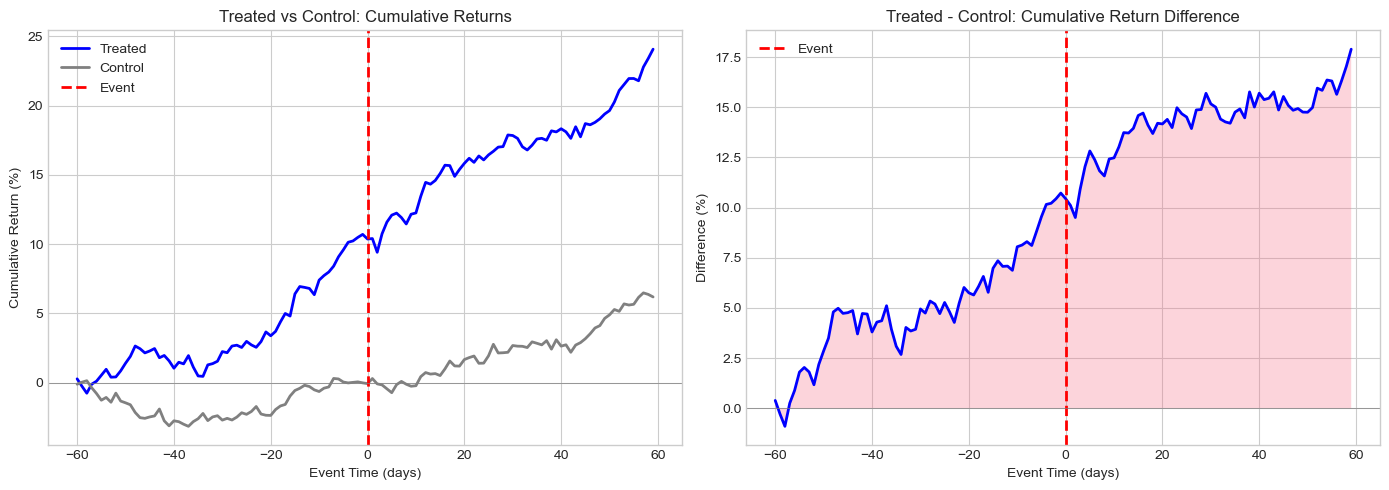

In [57]:
# Visualize DiD
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cum_ret = did_results['cum_returns']

# Cumulative returns by group
ax1 = axes[0]
for treated in [True, False]:
    group_data = cum_ret[cum_ret['treated'] == treated]
    label = 'Treated' if treated else 'Control'
    color = 'blue' if treated else 'gray'
    ax1.plot(group_data['event_time'], group_data['cum_return']*100, 
             label=label, color=color, linewidth=2)

ax1.axvline(0, color='red', linestyle='--', linewidth=2, label='Event')
ax1.axhline(0, color='gray', linestyle='-', linewidth=0.5)
ax1.set_xlabel('Event Time (days)')
ax1.set_ylabel('Cumulative Return (%)')
ax1.set_title('Treated vs Control: Cumulative Returns')
ax1.legend()

# Difference (treated - control)
ax2 = axes[1]
treated_cum = cum_ret[cum_ret['treated'] == True].set_index('event_time')['cum_return']
control_cum = cum_ret[cum_ret['treated'] == False].set_index('event_time')['cum_return']
diff = (treated_cum - control_cum) * 100

ax2.plot(diff.index, diff.values, 'b-', linewidth=2)
ax2.fill_between(diff.index, 0, diff.values, alpha=0.3)
ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='Event')
ax2.axhline(0, color='gray', linestyle='-', linewidth=0.5)
ax2.set_xlabel('Event Time (days)')
ax2.set_ylabel('Difference (%)')
ax2.set_title('Treated - Control: Cumulative Return Difference')
ax2.legend()

plt.tight_layout()
plt.show()

## 6. Confounding Events

### The Problem

Multiple events may occur around the same time:
- Earnings + M&A announcement
- Dividend + stock split
- Multiple news items on same day

### Solutions

1. **Exclusion**: Remove contaminated observations
2. **Indicator variables**: Control for confounding events
3. **Shorter windows**: Reduce chance of contamination
4. **Event-specific analysis**: Separate the effects

In [61]:
def simulate_confounded_events(n_events: int = 50,
                                pct_confounded: float = 0.3) -> pd.DataFrame:
    """
    Simulate event study with confounding events.
    """
    np.random.seed(42)
    
    data = []
    
    for i in range(n_events):
        # Primary event effect
        primary_effect = np.random.normal(0.02, 0.01)
        
        # Is there a confounding event?
        confounded = np.random.random() < pct_confounded
        confound_effect = np.random.normal(0.01, 0.02) if confounded else 0
        
        # Generate CAR
        noise = np.random.normal(0, 0.03)
        car = primary_effect + confound_effect + noise
        
        data.append({
            'event_id': i,
            'CAR': car,
            'confounded': confounded,
            'primary_effect': primary_effect,
            'confound_effect': confound_effect
        })
    
    return pd.DataFrame(data)


# Simulate data
confound_data = simulate_confounded_events(n_events=50, pct_confounded=0.3)

print("Confounding Events Analysis:")
print("="*60)
print(f"Total events: {len(confound_data)}")
print(f"Confounded events: {confound_data['confounded'].sum()} ({confound_data['confounded'].mean()*100:.0f}%)")

Confounding Events Analysis:
Total events: 50
Confounded events: 17 (34%)


In [63]:
# Compare analysis with and without confounding adjustment
print("\nAnalysis Comparison:")
print("-"*60)

# Full sample
full_mean = confound_data['CAR'].mean()
full_t, full_p = stats.ttest_1samp(confound_data['CAR'], 0)
print(f"\n1. Full Sample (N={len(confound_data)}):")
print(f"   Mean CAR: {full_mean*100:.2f}%")
print(f"   t-stat: {full_t:.2f} (p={full_p:.4f})")

# Exclude confounded
clean = confound_data[~confound_data['confounded']]
clean_mean = clean['CAR'].mean()
clean_t, clean_p = stats.ttest_1samp(clean['CAR'], 0)
print(f"\n2. Excluding Confounded (N={len(clean)}):")
print(f"   Mean CAR: {clean_mean*100:.2f}%")
print(f"   t-stat: {clean_t:.2f} (p={clean_p:.4f})")

# Regression with indicator
y = confound_data['CAR']
X = sm.add_constant(confound_data['confounded'].astype(float))
model = sm.OLS(y, X).fit()
print(f"\n3. Regression with Confound Indicator:")
print(f"   Intercept (clean events): {model.params['const']*100:.2f}%")
print(f"   Confound effect: {model.params['confounded']*100:+.2f}%")
print(f"   t-stat (intercept): {model.tvalues['const']:.2f}")


Analysis Comparison:
------------------------------------------------------------


AttributeError: 'dict' object has no attribute 'ttest_1samp'

In [ ]:
# Visualize confounding
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Distribution by confound status
ax1 = axes[0]
ax1.hist(confound_data[~confound_data['confounded']]['CAR']*100, bins=15, alpha=0.7, 
         label='Clean', color='blue', edgecolor='black')
ax1.hist(confound_data[confound_data['confounded']]['CAR']*100, bins=15, alpha=0.7, 
         label='Confounded', color='red', edgecolor='black')
ax1.axvline(0, color='black', linestyle='--', linewidth=1)
ax1.set_xlabel('CAR (%)')
ax1.set_ylabel('Frequency')
ax1.set_title('CAR Distribution by Confound Status')
ax1.legend()

# Box plot comparison
ax2 = axes[1]
bp = ax2.boxplot([confound_data[~confound_data['confounded']]['CAR']*100,
                   confound_data[confound_data['confounded']]['CAR']*100],
                  labels=['Clean', 'Confounded'],
                  patch_artist=True)
bp['boxes'][0].set_facecolor('blue')
bp['boxes'][1].set_facecolor('red')
for box in bp['boxes']:
    box.set_alpha(0.6)

ax2.axhline(0, color='gray', linestyle='--', linewidth=1)
ax2.set_ylabel('CAR (%)')
ax2.set_title('CAR by Confound Status')

plt.tight_layout()
plt.show()

## 7. Rolling Window Event Studies

### Motivation

Market conditions change over time:
- Beta may be time-varying
- Volatility regimes shift
- Market efficiency may evolve

### Rolling Estimation

Instead of fixed estimation window, use rolling parameters:

$$\hat{\beta}_{i,t} = f(R_{i,t-T}, ..., R_{i,t-1})$$

In [67]:
def rolling_event_study(ticker: str, 
                         event_dates: List[str],
                         rolling_window: int = 60,
                         event_window: Tuple[int, int] = (-1, 1)) -> pd.DataFrame:
    """
    Event study with rolling parameter estimation.
    """
    # Download data
    start = pd.to_datetime(min(event_dates)) - timedelta(days=rolling_window*2)
    end = pd.to_datetime(max(event_dates)) + timedelta(days=30)
    
    stock = yf.download(ticker, start=start, end=end, progress=False)['Close']
    market = yf.download('^GSPC', start=start, end=end, progress=False)['Close']
    
    df = pd.DataFrame({'stock': stock.squeeze(), 'market': market.squeeze()})
    df['stock_ret'] = df['stock'].pct_change()
    df['market_ret'] = df['market'].pct_change()
    df = df.dropna()
    
    # Rolling beta estimation
    def rolling_beta(window):
        if len(window) < 20:
            return np.nan
        cov = np.cov(window['stock_ret'], window['market_ret'])[0, 1]
        var = np.var(window['market_ret'])
        return cov / var if var > 0 else np.nan
    
    df['rolling_beta'] = df['stock_ret'].rolling(rolling_window).apply(
        lambda x: np.cov(x, df.loc[x.index, 'market_ret'])[0, 1] / np.var(df.loc[x.index, 'market_ret'])
        if len(x) >= 20 else np.nan
    )
    
    # Simple rolling beta calculation
    betas = []
    for i in range(len(df)):
        if i < rolling_window:
            betas.append(np.nan)
        else:
            window = df.iloc[i-rolling_window:i]
            cov = np.cov(window['stock_ret'], window['market_ret'])[0, 1]
            var = np.var(window['market_ret'])
            betas.append(cov / var if var > 0 else np.nan)
    
    df['rolling_beta'] = betas
    
    # Process events
    results = []
    for event_date in event_dates:
        event_dt = pd.to_datetime(event_date)
        
        if event_dt not in df.index:
            idx = df.index.get_indexer([event_dt], method='nearest')[0]
            if idx < 0:
                continue
            event_dt = df.index[idx]
        
        event_idx = df.index.get_loc(event_dt)
        
        # Get rolling beta at event time
        beta = df.iloc[event_idx]['rolling_beta']
        
        if np.isnan(beta):
            continue
        
        # Calculate CAR using rolling beta
        car = 0
        for t in range(event_window[0], event_window[1] + 1):
            idx = event_idx + t
            if 0 <= idx < len(df):
                expected = beta * df.iloc[idx]['market_ret']
                ar = df.iloc[idx]['stock_ret'] - expected
                car += ar
        
        results.append({
            'event_date': event_dt,
            'rolling_beta': beta,
            'CAR': car
        })
    
    return pd.DataFrame(results), df


# Example: Multiple earnings announcements for one stock
aapl_events = ['2023-02-02', '2023-05-04', '2023-08-03', '2023-11-02']

rolling_results, price_data = rolling_event_study('AAPL', aapl_events, 
                                                    rolling_window=60, 
                                                    event_window=(-1, 1))

print("Rolling Window Event Study Results:")
print("="*60)
print(rolling_results.to_string())

Rolling Window Event Study Results:
  event_date  rolling_beta       CAR
0 2023-02-02      1.475314  0.047533
1 2023-05-04      1.175724  0.025540
2 2023-08-03      0.965858 -0.049885
3 2023-11-02      1.182602 -0.011585


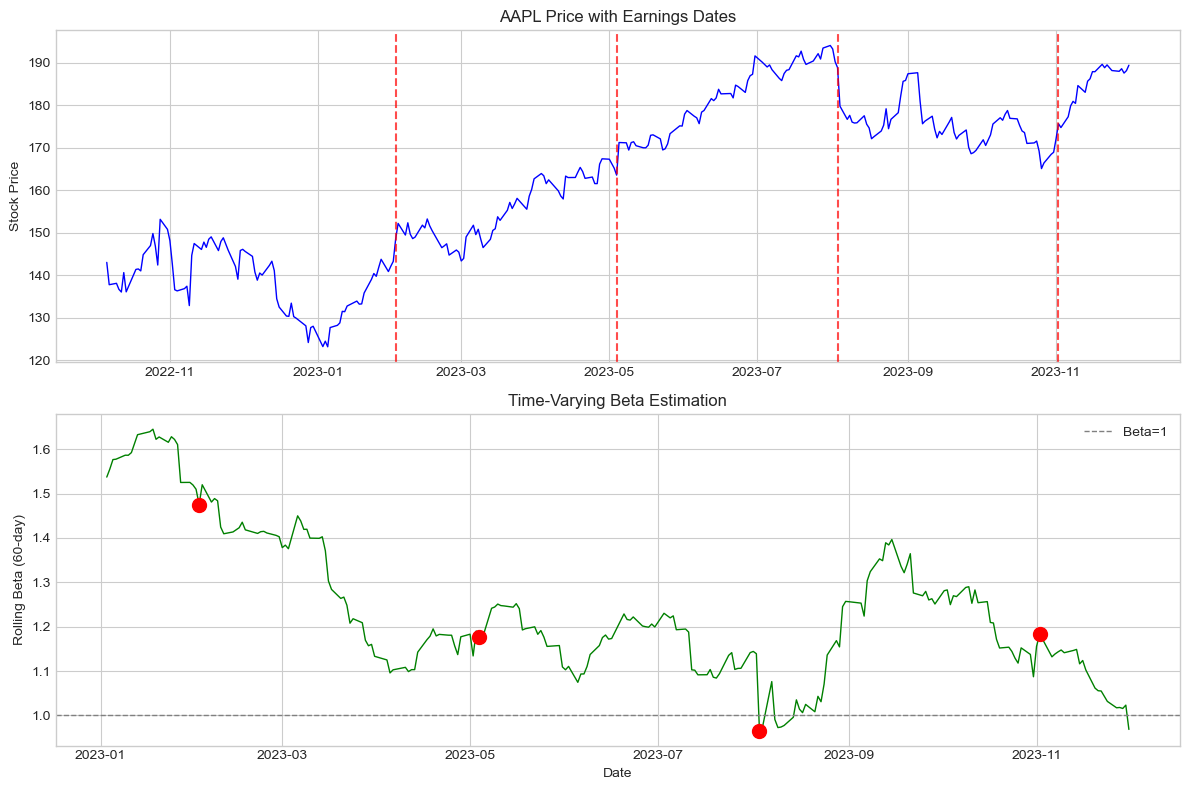

In [69]:
# Visualize rolling beta
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Price and events
ax1 = axes[0]
ax1.plot(price_data.index, price_data['stock'], 'b-', linewidth=1)
for date in rolling_results['event_date']:
    ax1.axvline(date, color='red', linestyle='--', alpha=0.7)
ax1.set_ylabel('Stock Price')
ax1.set_title('AAPL Price with Earnings Dates')

# Rolling beta
ax2 = axes[1]
ax2.plot(price_data.index, price_data['rolling_beta'], 'g-', linewidth=1)
for _, row in rolling_results.iterrows():
    ax2.scatter(row['event_date'], row['rolling_beta'], color='red', s=100, zorder=5)

ax2.axhline(1, color='gray', linestyle='--', linewidth=1, label='Beta=1')
ax2.set_ylabel('Rolling Beta (60-day)')
ax2.set_xlabel('Date')
ax2.set_title('Time-Varying Beta Estimation')
ax2.legend()

plt.tight_layout()
plt.show()

## 8. Event Study with Machine Learning Benchmarks

### Alternative Expected Return Models

Beyond CAPM and Fama-French:
- **LASSO/Ridge regression**: Many potential factors
- **Random forests**: Non-linear relationships
- **Neural networks**: Complex patterns

### Caution

- Overfitting risk
- Interpretability concerns
- May not improve inference

In [72]:
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

def ml_expected_returns(estimation_data: pd.DataFrame,
                         event_data: pd.DataFrame,
                         method: str = 'lasso') -> np.ndarray:
    """
    Estimate expected returns using ML methods.
    
    Uses lagged returns as features (simple demonstration).
    """
    # Create features (lagged returns)
    def create_features(data, lags=5):
        features = pd.DataFrame(index=data.index)
        for lag in range(1, lags + 1):
            features[f'lag_{lag}'] = data['stock_ret'].shift(lag)
            features[f'market_lag_{lag}'] = data['market_ret'].shift(lag)
        features['market_current'] = data['market_ret']
        return features.dropna()
    
    est_features = create_features(estimation_data)
    est_y = estimation_data.loc[est_features.index, 'stock_ret']
    
    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(est_features)
    
    # Fit model
    if method == 'lasso':
        model = LassoCV(cv=5, random_state=42)
    elif method == 'ridge':
        model = RidgeCV(cv=5)
    elif method == 'rf':
        model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
    
    model.fit(X_train, est_y)
    
    # Predict for event window
    evt_features = create_features(event_data)
    if len(evt_features) == 0:
        return np.array([])
    
    X_test = scaler.transform(evt_features)
    predictions = model.predict(X_test)
    
    return predictions, evt_features.index


# Demonstrate with synthetic data
print("ML-Based Expected Returns (Demonstration):")
print("="*60)
print("\nNote: This is a simplified demonstration. In practice:")
print("- Use more sophisticated features (factors, technical indicators)")
print("- Careful cross-validation to avoid look-ahead bias")
print("- Consider economic interpretability")

ML-Based Expected Returns (Demonstration):

Note: This is a simplified demonstration. In practice:
- Use more sophisticated features (factors, technical indicators)
- Careful cross-validation to avoid look-ahead bias
- Consider economic interpretability


## 9. Publication-Quality Reporting

### Best Practices

1. **Clearly state methodology**: Window length, benchmark, test statistics
2. **Report multiple windows**: Robustness across specifications
3. **Show distributions**: Not just means and t-stats
4. **Address clustering**: If events overlap in time
5. **Discuss economic significance**: Not just statistical

In [74]:
def create_publication_table(results_dict: Dict, title: str) -> str:
    """
    Create publication-quality LaTeX table.
    """
    latex = f"""\n
\\begin{{table}}[htbp]
\\centering
\\caption{{{title}}}
\\begin{{tabular}}{{lccccc}}
\\hline\\hline
Window & N & Mean CAR & Median CAR & t-stat & \\% Positive \\\\
\\hline
"""
    
    for window, stats in results_dict.items():
        sig = '$^{***}$' if stats['p'] < 0.01 else '$^{**}$' if stats['p'] < 0.05 else '$^{*}$' if stats['p'] < 0.10 else ''
        latex += f"{window} & {stats['n']} & {stats['mean']*100:.2f}\\%{sig} & {stats['median']*100:.2f}\\% & {stats['t']:.2f} & {stats['pct_pos']:.0f}\\% \\\\\n"
    
    latex += """\\hline\\hline
\\end{tabular}
\\begin{tablenotes}
\\small
\\item Notes: $^{***}$, $^{**}$, $^{*}$ indicate significance at 1\\%, 5\\%, 10\\% levels.
\\end{tablenotes}
\\end{table}
"""
    
    return latex


# Example results
example_results = {
    '(-1, +1)': {'n': 50, 'mean': 0.025, 'median': 0.020, 't': 3.45, 'p': 0.001, 'pct_pos': 72},
    '(0, 0)': {'n': 50, 'mean': 0.018, 'median': 0.015, 't': 2.89, 'p': 0.006, 'pct_pos': 68},
    '(-5, +5)': {'n': 50, 'mean': 0.032, 'median': 0.028, 't': 2.15, 'p': 0.036, 'pct_pos': 64},
}

latex_table = create_publication_table(example_results, "Abnormal Returns Around Event")
print("LaTeX Table Code:")
print(latex_table)

LaTeX Table Code:


\begin{table}[htbp]
\centering
\caption{Abnormal Returns Around Event}
\begin{tabular}{lccccc}
\hline\hline
Window & N & Mean CAR & Median CAR & t-stat & \% Positive \\
\hline
(-1, +1) & 50 & 2.50\%$^{***}$ & 2.00\% & 3.45 & 72\% \\
(0, 0) & 50 & 1.80\%$^{***}$ & 1.50\% & 2.89 & 68\% \\
(-5, +5) & 50 & 3.20\%$^{**}$ & 2.80\% & 2.15 & 64\% \\
\hline\hline
\end{tabular}
\begin{tablenotes}
\small
\item Notes: $^{***}$, $^{**}$, $^{*}$ indicate significance at 1\%, 5\%, 10\% levels.
\end{tablenotes}
\end{table}



## 10. Summary and Best Practices

### Key Extensions Covered

| Extension | Key Insight |
|-----------|-------------|
| **Intraday** | Account for microstructure noise, intraday patterns |
| **Bonds** | Use credit spreads, account for duration |
| **International** | Handle time zones, market linkages |
| **Diff-in-Diff** | Need valid control group, parallel trends |
| **Confounding** | Exclude or control for other events |
| **Rolling** | Parameters may be time-varying |

### General Best Practices

1. **Match method to question**: Not all extensions are needed
2. **Report robustness**: Multiple specifications
3. **Economic significance**: Beyond statistical significance
4. **Transparent methodology**: Replicability
5. **Address limitations**: No method is perfect

## 11. Exercises

### Exercise 1: Intraday Fed Announcement
Implement an intraday event study for a Fed interest rate announcement.

### Exercise 2: Credit Event Analysis
Analyze stock and bond responses to the same credit event.

### Exercise 3: Parallel Trends Test
Implement a formal test for parallel trends in a DiD setting.

In [76]:
# Exercise 3: Parallel Trends Test
def test_parallel_trends(data: pd.DataFrame, pre_periods: int = 5) -> Dict:
    """
    Test for parallel trends in pre-event period.
    
    Tests whether treated and control have similar trends before event.
    """
    # Get pre-event data
    pre_data = data[data['event_time'] < 0].copy()
    
    # Interaction of time with treatment
    pre_data['time_treated'] = pre_data['event_time'] * pre_data['treated'].astype(int)
    
    # Regression: R = a + b*time + c*treated + d*(time*treated)
    y = pre_data['return']
    X = sm.add_constant(pre_data[['event_time', 'treated', 'time_treated']].astype(float))
    
    model = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': pre_data['firm_id']})
    
    # Test: is d (time_treated) significantly different from zero?
    diff_trend = model.params['time_treated']
    diff_trend_t = model.tvalues['time_treated']
    diff_trend_p = model.pvalues['time_treated']
    
    return {
        'diff_trend_coef': diff_trend,
        't_stat': diff_trend_t,
        'p_value': diff_trend_p,
        'parallel_trends': diff_trend_p > 0.10  # Fail to reject = good!
    }


# Test on our DiD data
pt_results = test_parallel_trends(did_data)

print("Parallel Trends Test:")
print("="*60)
print(f"Differential trend coefficient: {pt_results['diff_trend_coef']:.6f}")
print(f"t-statistic: {pt_results['t_stat']:.3f}")
print(f"p-value: {pt_results['p_value']:.4f}")
print(f"\nConclusion: {'Parallel trends assumption supported' if pt_results['parallel_trends'] else 'Parallel trends assumption violated'}")

Parallel Trends Test:
Differential trend coefficient: 0.000015
t-statistic: 0.324
p-value: 0.7461

Conclusion: Parallel trends assumption supported


## References

- Barclay, M. J., & Litzenberger, R. H. (1988). Announcement effects of new equity issues and the use of intraday price data. *Journal of Financial Economics*, 21(1), 71-99.
- Bessembinder, H., Kahle, K. M., Maxwell, W. F., & Xu, D. (2009). Measuring abnormal bond performance. *Review of Financial Studies*, 22(10), 4219-4258.
- Angrist, J. D., & Pischke, J. S. (2009). *Mostly harmless econometrics: An empiricist's companion*. Princeton University Press.
- Goodman-Bacon, A. (2021). Difference-in-differences with variation in treatment timing. *Journal of Econometrics*, 225(2), 254-277.